In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [2]:
batch_size= 2
#batch_size=4에서도 memory 할당 오류가 발생해 batch_size=1로 하였더니, 
#optimizer에서 Expected more than 1 value per channel when training, got input size torch.Size([1, 1024]) 오류가 발생해
#서치해본 결과 batch_size>1로 해야한다는 팁과 DataLoader에 drop_last=True를 하라는 팁이 있어서
#둘 다 적용하여 batch_size=2로 설정하고 DataLoader에는 drop_last=True를 추가하였습니다.
learning_rate= 0.0001
epoch= 10

n_node= 1024 #customized last layer-fully connected layer의 노드 수: 64, 128, 256, 512, 1024
dropratio= 0.5 #얼마나 드랍시킬지 inverse keepratio

imgsize= 256

In [3]:
img_dir="bakery/train"
train_data= dset.ImageFolder(img_dir, transforms.Compose([
    transforms.CenterCrop(imgsize*2),
    transforms.RandomCrop(imgsize),
    transforms.RandomHorizontalFlip(),
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))
print(train_data.__len__())

train_batch= data.DataLoader(train_data, batch_size= batch_size,
                            shuffle= True, num_workers= 2, drop_last=True)

60


In [4]:
#2. Dev data
img_dir="bakery/val"
dev_data= dset.ImageFolder(img_dir, transforms.Compose([
    #transforms.Scale(256),
    #transforms.RandomSizedCrop(224),
    
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

dev_batch=data.DataLoader(dev_data, batch_size= batch_size, 
                           shuffle=True, num_workers= 2, drop_last=True)

In [5]:
#3. Test data
img_dir="bakery/test"
test_data= dset.ImageFolder(img_dir, transforms.Compose([
    #transforms.Scale(256),
    #transforms.RandomSizedCrop(224),
    
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

test_batch=data.DataLoader(test_data, batch_size= batch_size, 
                           shuffle=True, num_workers= 2, drop_last=True)

In [6]:
nclass= len(train_data.classes)
print("# of classes: %d"%nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Traning: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# of classes: 2
['cake', 'pie']
{'cake': 0, 'pie': 1}
60
Traning: 60, Dev: 20, Test: 20


In [7]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cake', 'pie']
['cake', 'pie']
['cake', 'pie']


In [8]:
vgg= models.vgg19(pretrained= True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [9]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [10]:
base_dim= 64
fsize= imgsize/32

class MyYGG(nn.Module):
    def __init__(self):
        super(MyYGG, self).__init__()
        #[0]: features(conv), [1]: classifier(fc)->customized
        self.layer0= nn.Sequential(*list(vgg.children())[0])
        
        self.layer1= nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), # 0.3 만큼 drop 하자.
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass), #cake, pie -> class 2개이므로 nclass= 2
        )
        
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)    
    
    def forward(self, x):
        #layer0의 사이즈를 무식하게 프린트하여 알아낼 수 있음(batchsize, x, x, x)
        #print(x.size())
        out= self.layer0(x)
        out= out.view(out.size(0), -1)
        out= self.layer1(out)
        return out

In [11]:
model= MyYGG()

for params in model.layer0.parameters():
    params.required_grad= False
    
for params in model.layer1.parameters():
    params.required_grad= True

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:35: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [12]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
loss_func= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.layer1.parameters(), lr=learning_rate)

In [15]:
import utils

total_time= 0
disp_step= 10

to_train= True
if (to_train==False):
    netname="./nets/cakepie_vgg19_10.pkl" #마지막으로 학습된 epoch의 pkl을 넣으면됨
    model= torch.load(netname)
    
else:
    print("3 layer, n_node: %d, dropratio: %.2f"%(n_node, dropratio))
    model.eval()
    train_corr= utils.ComputeCorr(train_batch, model)
    dev_corr= utils.ComputeCorr(dev_batch, model)
    test_corr= utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname= './nets/cakepie_vgg19'
    
    x_epoch= []
    y_train_err= []
    y_dev_err= []
    y_test_err= []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    print("pass")
    
    #학습을 재시작한다면
    #netname='./nets/media_pre_vgg19.pkl'
    #model= torch.load(netname)
    #파라미터 학습 여부 결정
    #for params in model.layer0.parameters():
    #    params.required_grad= False
    #for params in model.layer1.parameters():
    #    params.required_grad= True
    #for i in range(34, epoch) -> 34: 이전 학습에서 직전에 저장된 pkl epoch
    
    #재시작하지 않는다면
    for i in range(epoch):
        start_time= time.time()
        print("%d.."%i),
        for img, label in train_batch:
            img= Variable(img)
            label= Variable(label)
            
            optimizer.zero_grad()
            output= model(img)
            loss= loss_func(output, label)
            loss.backward()
            optimizer.step()
            print("pass2")
            
        end_time= time.time()
        duration= end_time - start_time
        total_time += duration
        if(i%disp_step == 0) or (i==epoch-1):
            #torch.save(model, netname+'_%d.pkl'%i)
            print("\n[%d/%d] loss: %.3f, "%(i, epoch, (loss.cpu()).data.numpy())),
                
            model.eval()
            
            print("pass3")
            train_corr= utils.ComputeCorr(train_batch, model)
            dev_corr= utils.ComputeCorr(dev_batch, model)
            test_corr= utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f"
                %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec..."%(total_time))
                
            #graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
                
    print("Total time: %.2f sec"%total_time)

3 layer, n_node: 1024, dropratio: 0.50
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
 
.
.
.
.
.
.
.
.
.
.
 
.
.
.
.
.
.
.
.
.
.
 
Correct of train: 53.33, dev: 50.00, test: 60.00
pass
0.. pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2

[0/10] loss: 0.863,  pass3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
 
.
.
.
.
.
.
.
.
.
.
 
.
.
.
.
.
.
.
.
.
.
 
Correct of train: 63.33, dev: 55.00, test: 45.00 time: 328.04 sec...
1.. pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
2.. pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
pass2
3.. pass2
pass2
pass2
pass2
pass2
pass2
pass2


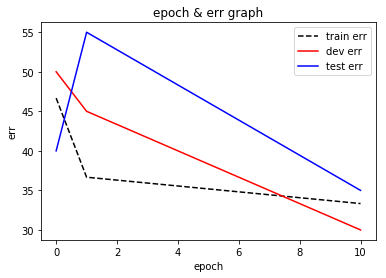

In [18]:
#cuda error 발생해서 utils.py의 .cuda()를 모두 제거하고 돌렸습니다.
#학습이 진행되고 있는 건지 확인이 어려워 utils.py - ComputeCorr 매 반복마다 print(".")을 추가했습니다.
#print(".", end="")라고 추가하면 end가 정의되지 않았다고 오류가 나던데... 이유가 뭘까. -> py2.7버전이라 그런 것 같기도...
#중간 중간 에러가 계속 발생해, 어디서 에러가 나는지 판단하기 위해 중간중간 "pass"를 프린트했습니다.
if(to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

Normalized confusion matrix


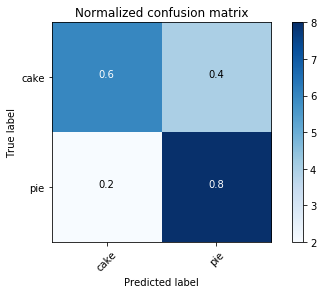

Confusion matrix, without normalization


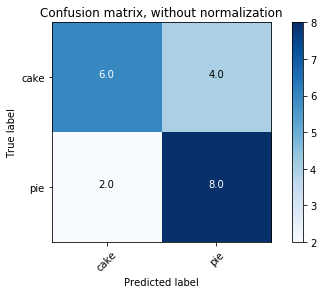

	 acc  |	 pre  |	 rec  |	 f1
 cake: 0.70 |	 0.75 |	 0.60 |	 0.67
 pie: 0.70 |	 0.67 |	 0.80 |	 0.73
*accuracy: 0.70, precision: 0.71, recall: 0.70, *f1 score: 0.70
[AP] cake: 0.80 pie: 0.76 
[mAP] 0.780
[miAP] 0.850


(array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0]),
 array([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]),
 array([0.5337339 , 0.61156285, 0.55565643, 0.86350399, 0.60523236,
        0.55112207, 0.56975365, 0.50785774, 0.50025082, 0.64217836,
        0.59493256, 0.6120829 , 0.60167712, 0.52883244, 0.73258638,
        0.73669243, 0.71851462, 0.7156986 , 0.50579399, 0.5443058 ]))

In [20]:
model.eval() #evaluation(test) mode로 바꾸기
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


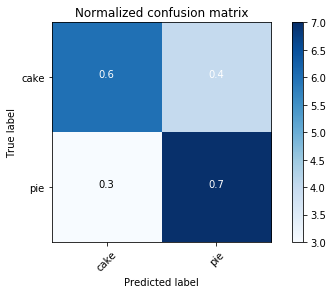

Confusion matrix, without normalization


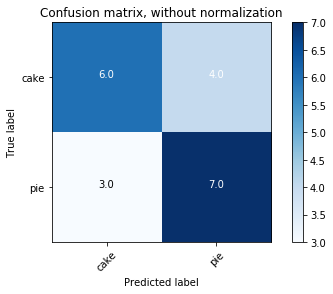

	 acc  |	 pre  |	 rec  |	 f1
 cake: 0.65 |	 0.67 |	 0.60 |	 0.63
 pie: 0.65 |	 0.64 |	 0.70 |	 0.67
*accuracy: 0.65, precision: 0.65, recall: 0.65, *f1 score: 0.65
[AP] cake: 0.79 pie: 0.76 
[mAP] 0.772
[miAP] 0.825


In [21]:
model.eval()
_, _, _=utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: cake
 True predicted images/total cake category: 6 / 10
Predicted probability: [0.59493256 0.40506747]


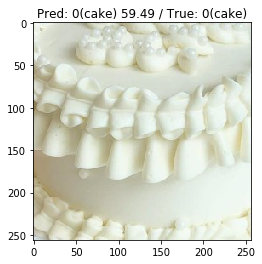

Predicted probability: [0.55112207 0.4488779 ]


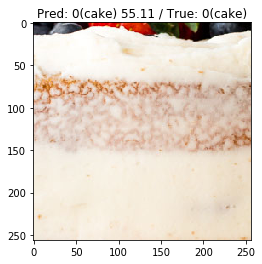

 False predicted images/total cake category: 4 / 10
Predicted probability: [0.2674136 0.7325864]


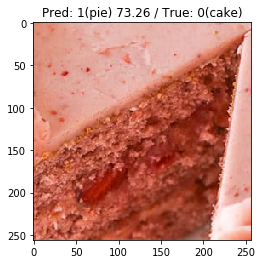

Predicted probability: [0.49420604 0.505794  ]


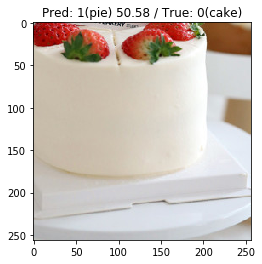

Category: pie
 True predicted images/total pie category: 8 / 10
Predicted probability: [0.13649599 0.863504  ]


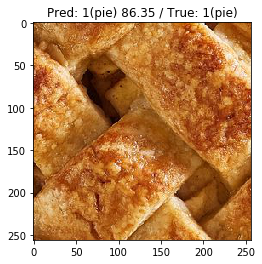

Predicted probability: [0.49214223 0.50785774]


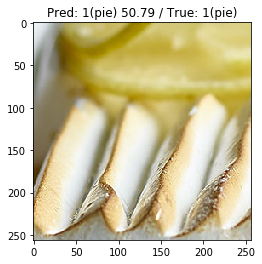

 False predicted images/total pie category: 2 / 10
Predicted probability: [0.60523236 0.39476767]


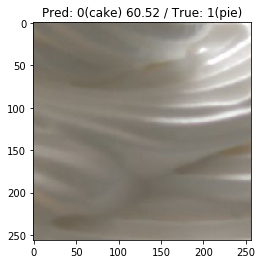

Predicted probability: [0.56975365 0.43024632]


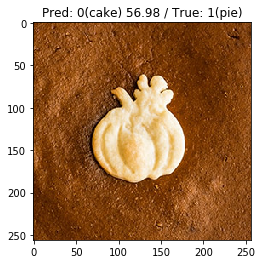

In [22]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size,i_n=2)